In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import load_model
from depth_anything_v2.dpt import DepthAnythingV2


xFormers not available
xFormers not available


In [2]:

def show_3d(pred):
    # 三维展示像素值大小
    h,w = pred.shape
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, pred, cmap='coolwarm')
    plt.show()

def align(pred,gt):
    return pred * (np.median(gt) / np.median(pred))

def show_metric(pred, gt):
    rmse = np.sqrt(np.mean((pred - gt) ** 2))
    mae = np.mean(np.abs(pred - gt))
    absrel = np.median(np.abs(pred - gt) / (gt+1e-6))
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"ABS REL: {absrel}")

In [3]:
model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
load_from = "/Disk_2/ZanXin/Depth-Anything-V2/checkpoints/depth_anything_v2_metric_hypersim_vitl.pth"
depth_anything = DepthAnythingV2(**{**model_configs['vitl'], 'max_depth': 100})
depth_anything.load_state_dict(torch.load(load_from, map_location='cpu'))
depth_anything = depth_anything.to('cuda').eval()


model_path = "../train_checkpoints/UCL/latest.pth"

model = load_model(model_path, max_depth=100)
model = model.to('cuda').eval()



FileNotFoundError: [Errno 2] No such file or directory: '/Disk_2/ZanXin/Depth-Anything-V2/checkpoints/depth_anything_v2_metric_hypersim_vitl.pth'

### V通道

(1007, 1162, 3)


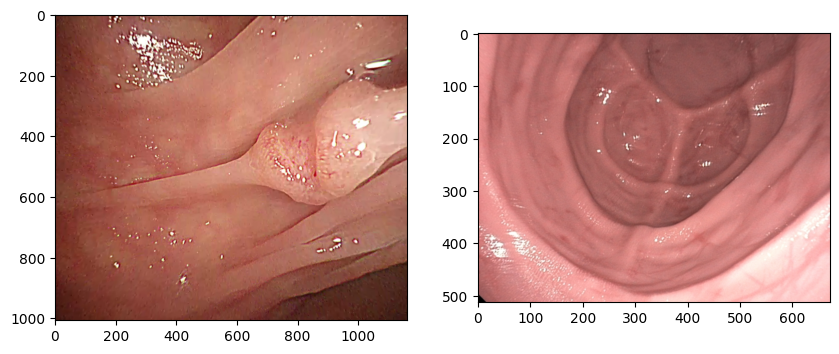

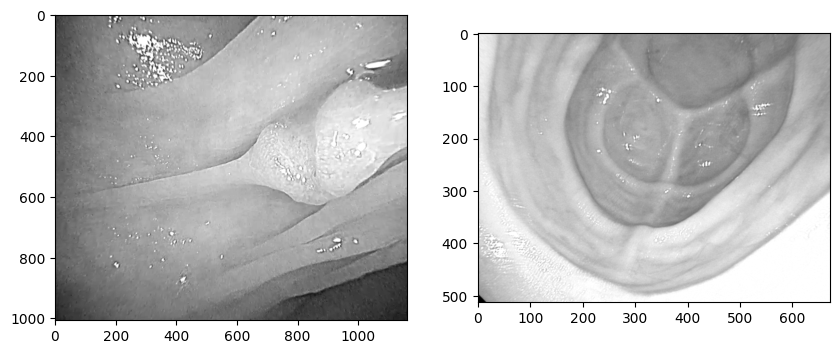

In [60]:
import cv2

img = cv2.imread("/home/zanxin/jiahan/huaxi_real_24/scenes/scene1/0000039.png")
img2 = cv2.imread("/home/zanxin/jiahan/huaxi_real_24/scenes/scene1/0000240.png")

img_c3vd = cv2.imread("/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t2_a/00001.jpg")
# img = cv2.imread("/home/zanxin/jiahan/huaxi_dataset/undist_20240313_174853_测大小-15mm-带蒂/Frame20240313_175217_0002915_frame.jpg")
# img2 = cv2.imread("/home/zanxin/jiahan/huaxi_dataset/undist_20240313_174853_测大小-15mm-带蒂/Frame20240313_175217_0002915_frame.jpg")
print(img.shape)

bgr = img[...,::-1]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[...,::-1])
plt.subplot(1,2,2)
plt.imshow(img_c3vd[...,::-1])

# # 转换HSV通道
# V_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# V_channel = V_channel[...,2:]
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plt.imshow(V_channel, cmap='gray')
# plt.figure()
# plt.imshow(gray, cmap='gray')

V_channel_ours = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
V_channel_c3vd = cv2.cvtColor(img_c3vd, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(V_channel_ours[...,2:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(V_channel_c3vd[...,2:], cmap='gray')


18.566734


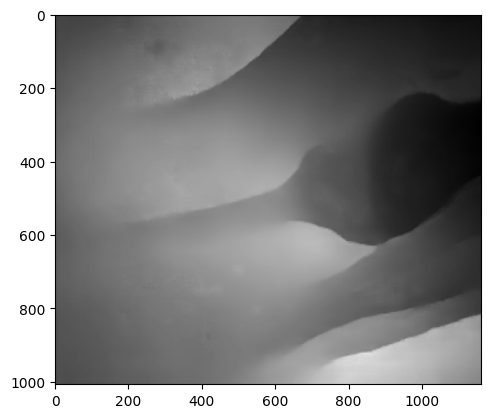

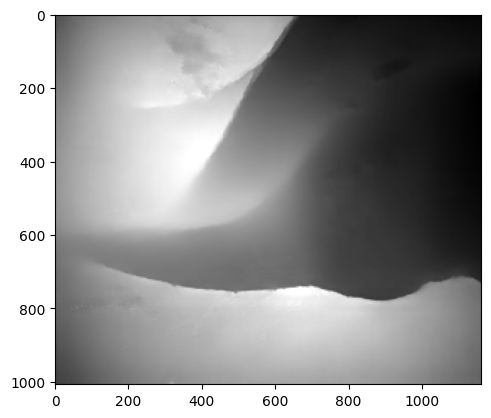

In [56]:

depth = model.infer_image(img)
print(depth.max())
plt.imshow(depth, cmap='gray', vmax=20)

depth_bgr = model.infer_image(img2)
plt.figure()
plt.imshow(depth_bgr, cmap='gray', vmax=20)

(960, 1152, 1)


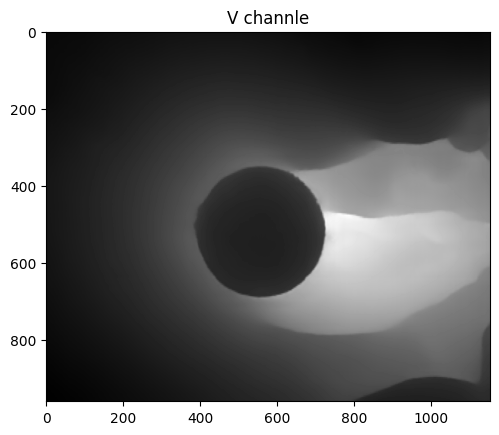

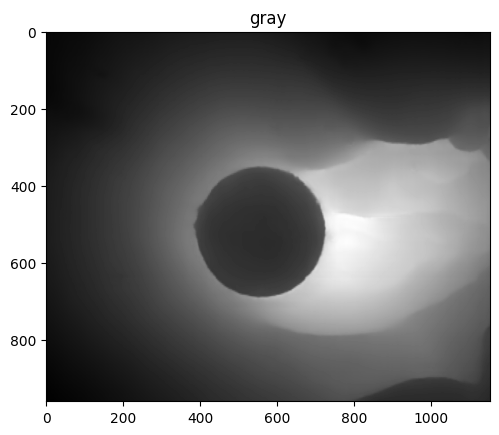

In [22]:

print(V_channel.shape)

depth_gray = model.infer_image(gray)
depth = model.infer_image(V_channel)

plt.figure()
plt.title('V channle')
plt.imshow(depth, cmap='gray')

plt.figure()
plt.title("gray")
plt.imshow(depth_gray,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4142135623730951].


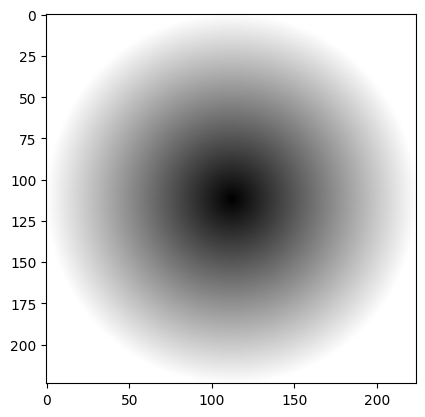

In [4]:
# 生成一张中间黑，向四周逐渐变暗的图，距离中心相同距离的像素值相同
def generate_heatmap():
    heatmap = np.zeros((224, 224))
    center = (112, 112)
    for i in range(224):
        for j in range(224):
            heatmap[i, j] = 1 - np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2) / 112
    return heatmap

# 给输入图片加高斯噪声
def add_gaussian_noise(image, mean=0, std=1):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

# 生成一张高斯噪声的三通道图片
def generate_noise_image(h,w):
    noise = np.random.normal(0, 1, (h, w, 3))
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
    return (noise*255).astype(np.uint8)


def swap_part(img, part1, part2, size):
    # h,w,_ = img.shape
    tmp = img[part1[0]:part1[0]+size[0], part1[1]:part1[1]+size[1]].copy()
    img[part1[0]:part1[0]+size[0], part1[1]:part1[1]+size[1]] = img[part2[0]:part2[0]+size[0], part2[1]:part2[1]+size[1]]
    img[part2[0]:part2[0]+size[0], part2[1]:part2[1]+size[1]] = tmp
    # tmp = img[:int(part1[1]), :int(w/2)].copy()
    # img[:int(h/2), :int(w/2)] = img[int(h/2):, int(w/2):]
    # img[int(h/2):, int(w/2):] = tmp
    return img

def flip_part(img, start, size):
    tmp = img[start[0]:start[0]+size[0], start[1]:start[1]+size[1]].copy()
    tmp = np.flip(tmp, axis=0)
    img[start[0]:start[0]+size[0], start[1]:start[1]+size[1]] = np.flip(tmp, axis=1)
    return img

sample = generate_heatmap()
# [224,224] -> [224,224,3]
sample = np.stack([sample, sample, sample], axis=2)
sample = 1 - sample
plt.imshow(sample, cmap='gray')

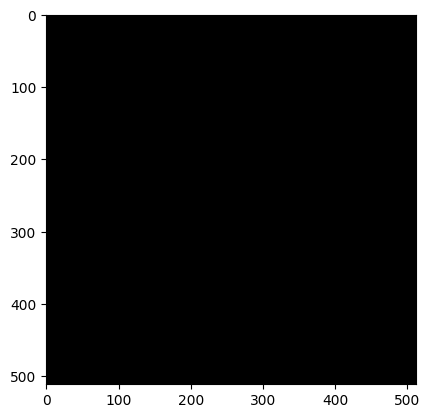

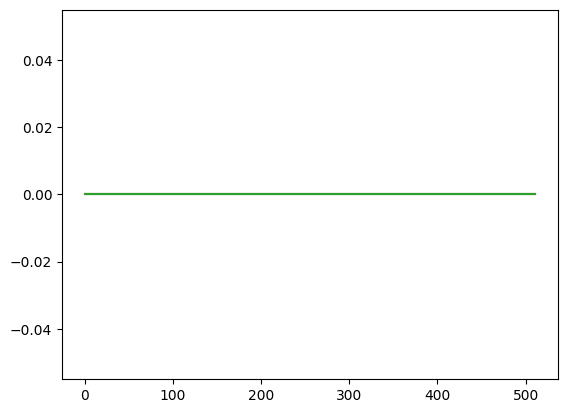

In [11]:



# img_path = "/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/00000.jpg"
# gt = np.load("/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/depth_gt/00000.npy")
img_path = "/home/zanxin/jiahan/.dataset4SCDepth/scene_trans_t1_a/00000.jpg"
gt = np.load("/home/zanxin/jiahan/.dataset4SCDepth/scene_trans_t1_a/depth_gt/00000.npy")
# img_path = "/home/zanxin/jiahan/T1/C_T1_L1_1_resized/FrameBuffer_0382.png"
# img_path = "/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/FrameBuffer_0001.png"
# gt = np.load("/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/depth_gt/FrameBuffer_0001.npy")
# img = (sample * 255).astype(np.uint8)
# gt = 1/(np.power(sample,2) + 1)[...,0]

img = cv2.imread(img_path).astype(np.uint16)
# 翻转img
# start, size = (100,200), (300,300)
# img = flip_part(img, start, size)
# 交换两个区域
# part1, part2, size = (100,200), (300,300), (150, 200)
# img = swap_part(img, part1, part2, size)

# img = add_gaussian_noise(img, mean=0, std=10000)
# img = generate_noise_image(img.shape[0], img.shape[1])
img = np.zeros((512,512,3))*255
# img = generate_heatmap()
# img = img+img.min()
# img = 255 * (img - img.min()) / (img.max() - img.min())
# img = img.astype(np.uint8)
# img = np.stack([img, img, img], axis=2).astype(np.uint8)

# R通道赋值为0
# img[...,2] = 0

# 三通道图大于255的变成255
# img = np.clip(img+10, 0, 255).astype(np.uint8)
# img[...,0] = 255

img = img.astype(np.uint8)
plt.figure()
plt.imshow(img[...,::-1])

plt.figure()
plt.plot(img[200])

output = model.infer_image(img)
output_dany = depth_anything.infer_image(img)


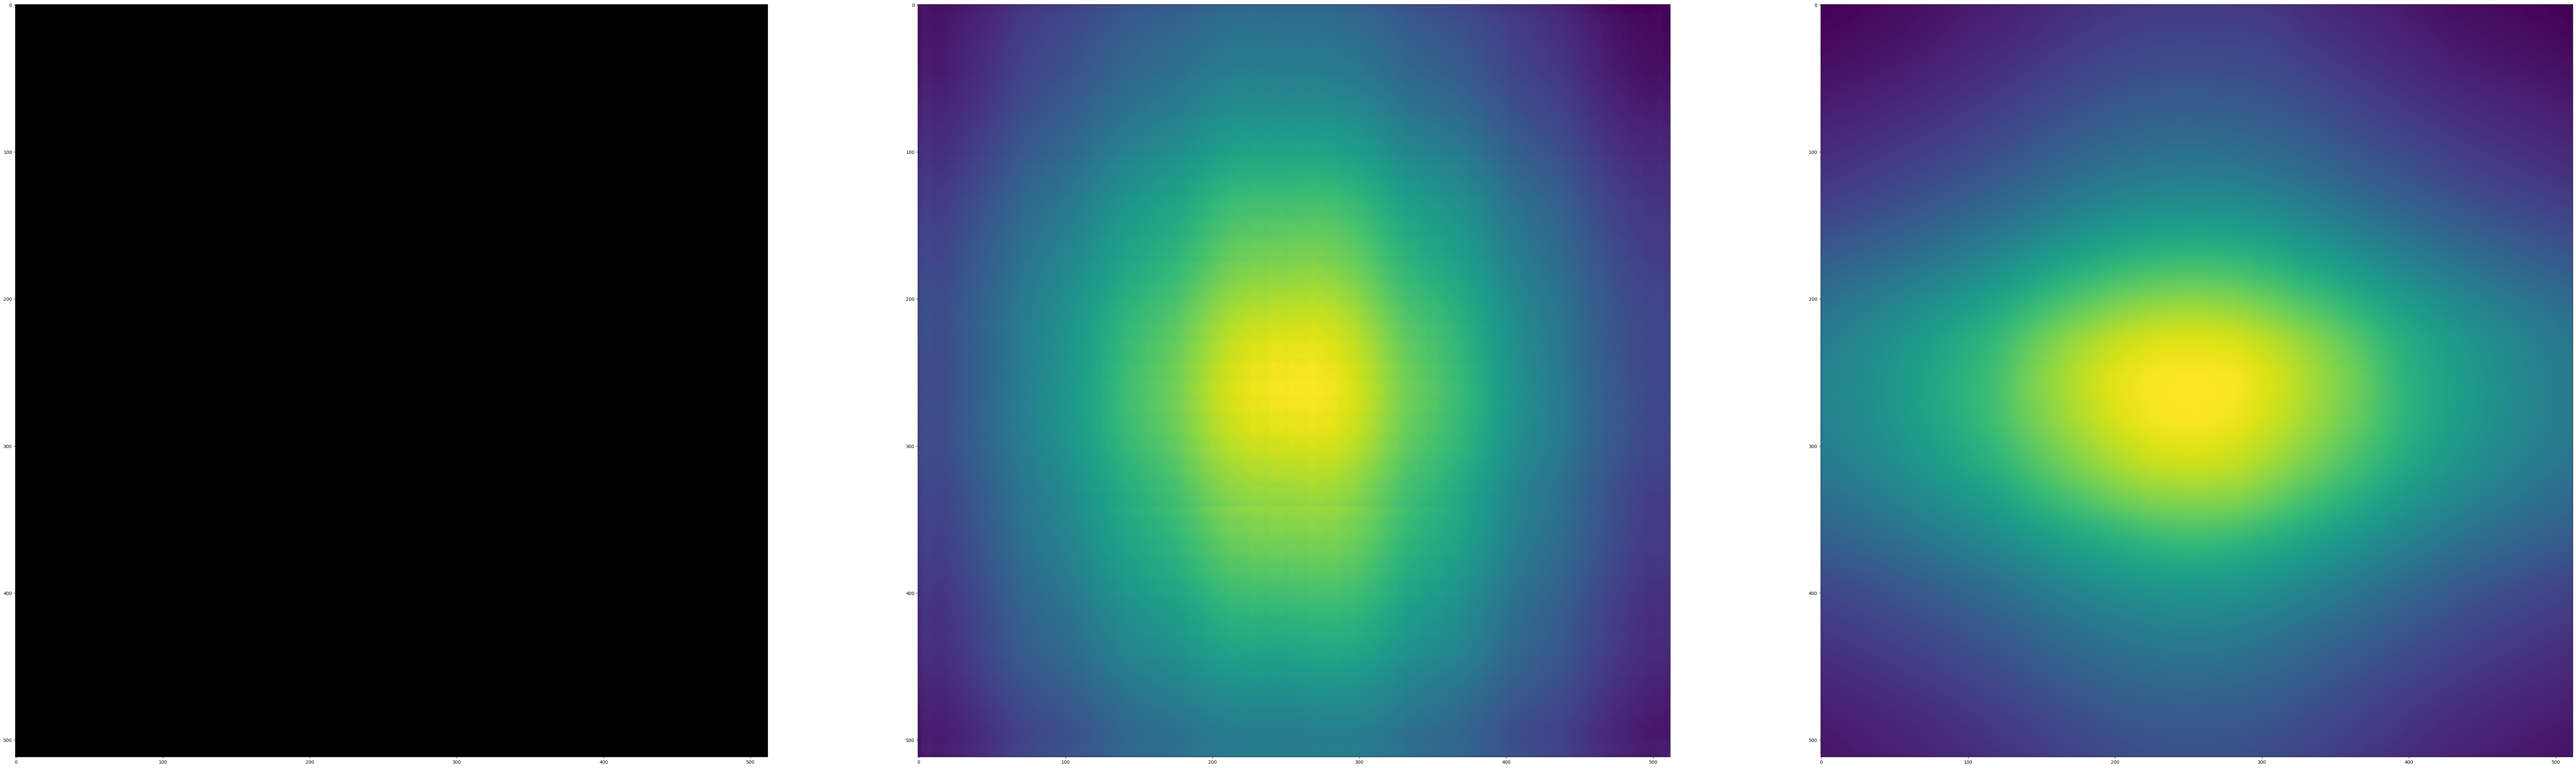

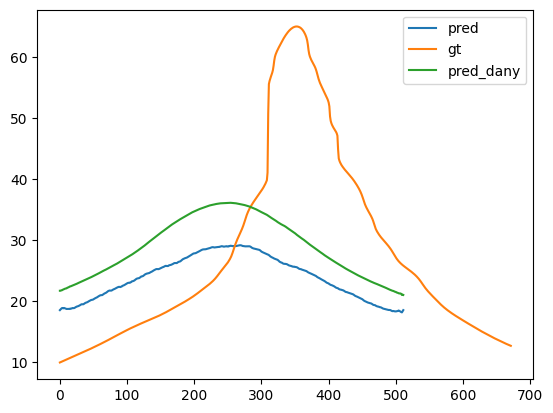

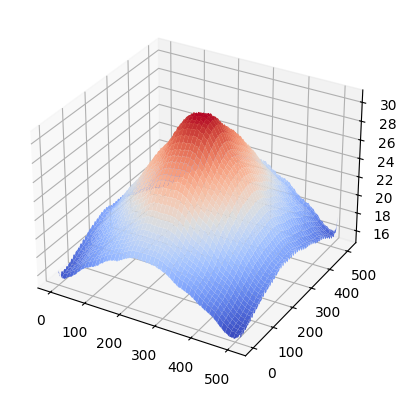

ValueError: operands could not be broadcast together with shapes (512,512) (512,672) 

In [12]:
pred = output.copy()
pred_dany = output_dany.copy()

pred = align(pred,gt)
pred_dany = align(pred_dany,gt)

# 翻转回来
# pred = flip_part(pred, start, size)
# pred_dany = flip_part(pred_dany, start, size)
# 交换回来
# pred = swap_part(pred, part1, part2, size)
# pred_dany = swap_part(pred_dany, part1, part2, size)


# left is pred, right is pred_dany
plt.figure(figsize=(100,100))
plt.subplot(1,3,1)
plt.imshow(img[...,::-1])
plt.subplot(1,3,2)
plt.imshow(pred)
plt.subplot(1,3,3)
plt.imshow(pred_dany)


plt.figure()
plt.plot(pred[200], label='pred')
plt.plot(gt[200,], label='gt')
plt.plot(pred_dany[200], label='pred_dany')
plt.legend()

show_3d(pred)

show_metric(pred, gt)
print("------")
show_metric(pred_dany,gt)

In [3]:
# run.py 的加载方式

DEVICE = "cuda"

model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }

from depth_anything_v2.dpt import DepthAnythingV2
depth_anything = DepthAnythingV2(**{**model_configs['vitl'], 'max_depth': 200})
# depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/metric_depth/123.pth", map_location='cpu'), strict=True)
depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/train_checkpoints/UCL/latest.pth", map_location='cpu')['model'], strict=True)
depth_anything = depth_anything.to(DEVICE).eval()

In [2]:
# tmp
import torch

tmp = torch.load("/Disk_2/ZanXin/Depth-Anything-V2/train_checkpoints/SimCol/latest.pth", map_location='cpu')

In [7]:
print(tmp.keys())
# torch.save(tmp['model'], "/Disk_2/ZanXin/Depth-Anything-V2/train_checkpoints/SimCol/train_from_latest.pth")
print(tmp['model'])
print(tmp['model'].items())

dict_keys(['model', 'optimizer', 'epoch', 'previous_best'])
OrderedDict([('pretrained.cls_token', tensor([[[ 0.0050, -0.0017, -0.0050,  ..., -0.0057,  0.0037,  0.0016]]])), ('pretrained.pos_embed', tensor([[[ 0.0050, -0.0017, -0.0050,  ..., -0.0057,  0.0037,  0.0016],
         [-0.0113,  0.0108,  0.0011,  ...,  0.0141, -0.0102, -0.0083],
         [-0.0108,  0.0098, -0.0037,  ...,  0.0117, -0.0081,  0.0144],
         ...,
         [ 0.0016,  0.0020,  0.0116,  ...,  0.0023, -0.0019,  0.0143],
         [ 0.0065,  0.0039,  0.0141,  ...,  0.0037,  0.0030,  0.0216],
         [ 0.0150,  0.0058,  0.0149,  ...,  0.0026,  0.0005,  0.0207]]])), ('pretrained.mask_token', tensor([[0., 0., 0.,  ..., 0., 0., 0.]])), ('pretrained.patch_embed.proj.weight', tensor([[[[ 1.9420e-03, -5.0173e-03, -2.6684e-03,  ..., -1.3695e-03,
           -2.4194e-05,  5.3518e-03],
          [ 7.2528e-03,  2.9893e-03, -5.6807e-03,  ..., -1.0394e-03,
           -4.2778e-03,  4.0324e-03],
          [ 1.2293e-02,  3.2097e-03,